In [1]:
import game_v10
from player_p1 import PlayerP1
import numpy

Using TensorFlow backend.


In [2]:
game_train = game_v10.GameV10(mode="train")
game_test = game_v10.GameV10(mode="test", random_data=False)

In [3]:
state_size = game_train.observation_space.shape[0]
action_size = game_train.action_space.n

In [4]:
player = PlayerP1(state_size, action_size)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [5]:
class Logger(object):
    def __init__(self):
        self.record_list = []
        self.validation_list = []
        
    def record(self, d):
        self.record_list.append(d)
        
    def val(self, d):
        self.validation_list.append(d)

from collections import deque
import random

def run(player, game, logger, mode, episode=100, batch_size=32, memory_size=1024, test_game=None):
    assert mode in ["train", "test"]
    exp = deque(maxlen=memory_size)
    for e in range(episode):
        done= False
        power_list = []
        state = game.reset()
        while not done:
            action = player.get_action(state)
            next_state, reward, done, info = game.step(action)
            exp.append((state, action, reward, next_state, done))
            state = next_state
            power_list.append(game.power)
        if len(exp) >= memory_size:
            states, actions, rewards, next_states, dones = select_batch(exp, batch_size)
            player.train_model(states, actions, rewards, next_states, dones)
        
        logger.record(power_list)
        if test_game is not None:
            p = validation(player, test_game)
            logger.val(p)
        
def validation(player, game):
    done= False
    power_list = []
    state = game.reset()
    while not done:
        action_prob = player.get_action_prob(state)
        action = numpy.argmax(action_prob)
        next_state, reward, done, info = game.step(action)
        state = next_state
        power_list.append(game.power)
    return game.power
    
        
def select_batch(exp, batch_size):
    tpls = random.sample(exp, batch_size)
    states = [t[0] for t in tpls]
    actions = [t[1] for t in tpls]
    rewards = [t[2] for t in tpls]
    next_states = [t[3] for t in tpls]
    dones = [t[4] for t in tpls]
    return _v(states), _v(actions), _v(rewards), _v(next_states), _v(dones)

def _v(arr_list):
    # explode
    arr = numpy.vstack([v for v in arr_list])
    return arr

In [6]:
logger_train = Logger()
run(player, game_train, logger_train, "train", episode=5000, batch_size=512, memory_size=4096, test_game=game_test)
player.actor.save_weights("model/actor_weight.h5")
player.critic.save_weights("model/critic_weight.h5")


Instructions for updating:
Use tf.cast instead.


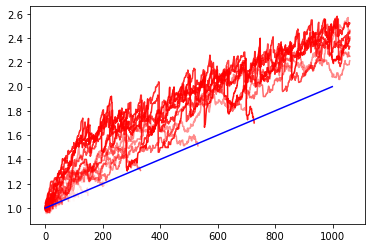

In [11]:
import matplotlib.pyplot as plt

def f(i):
    if i <= 10:
        return True
    elif i <= 100 and i % 2 == 0:
        return True
    elif i <= 1000 and i % 10 == 0:
        return True
    elif i <= 10000 and i % 100 == 0:
        return True
    else:
        return False

n = len(logger_train.record_list)
for i in range(n):
    if f(i):
        d = logger_train.record_list[i]
        plt.plot(range(len(d)), d, alpha=i/n, c="r")
x = numpy.array(range(1000))
cutline = x * 0.001 + 1
plt.plot(x, cutline, c="b")

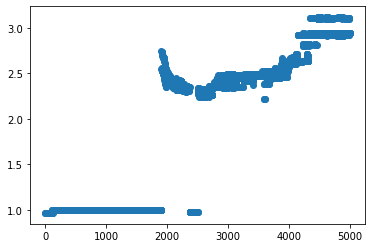

In [9]:
n = len(logger_train.validation_list)
plt.scatter(range(n), logger_train.validation_list)

In [ ]:
logger_train.validation_list